# Intro
In this notebook we are interested in training a recurrent neural network (RNN) on Trump's tweets and try to generate "Trump-like" tweets. 

In [218]:
import os
import requests
import zipfile
import tarfile
import shutil
import json
import time
import sys
import string
import re
import numpy as np
import pandas as pd
from glob import glob
from string import Template
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.python.ops import io_ops
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN
from keras.layers.embeddings import Embedding
from keras.layers import Flatten
from keras.preprocessing import sequence
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D


from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

## Read the data
The data comes from http://www.trumptwitterarchive.com/archive. I find this website so interesting and amazing. I didn't scrape from twitter because sometimes Trumps delete some of his tweets, and this source archives those deleted tweets after 2016.    
Let's do some EDA.

In [219]:
trump_tweet=pd.read_json('trump_tweets_complete.json')
trump_tweet['date']=pd.to_datetime(trump_tweet['date'])

In [220]:
trump_tweet.shape

(54442, 8)

In [221]:
trump_tweet.columns

Index(['id', 'text', 'isRetweet', 'isDeleted', 'device', 'favorites',
       'retweets', 'date'],
      dtype='object')

In [222]:
trump_tweet.date.describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                   54442
unique                  53934
top       2020-05-31 02:27:36
freq                        7
first     2009-05-04 18:54:25
last      2020-10-24 20:13:08
Name: date, dtype: object

There are 54442 tweets in total, from 2009-05-04 to 2020-10-24 (the latest archive).   

In [223]:
trump_tweet.head(10)

,id,text,isRetweet,isDeleted,device,favorites,retweets,date
0,98454970654916600,Republicans and Democrats have both created ou...,f,f,TweetDeck,49,255,2011-08-02 18:07:48
1,1234653427789070300,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03 01:34:50
2,1218010753434820600,RT @CBS_Herridge: READ: Letter to surveillance...,t,f,Twitter for iPhone,0,7396,2020-01-17 03:22:47
3,1304875170860015600,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,2020-09-12 20:10:58
4,1218159531554898000,RT @MZHemingway: Very friendly telling of even...,t,f,Twitter for iPhone,0,9081,2020-01-17 13:13:59
5,1319761576996573200,THANK YOU to all of the Great American Patriot...,f,f,Twitter for iPhone,100564,18992,2020-10-23 22:04:14
6,1217962723234984000,RT @WhiteHouse: President @realDonaldTrump ann...,t,f,Twitter for iPhone,0,25048,2020-01-17 00:11:56
7,1315779944002199600,"“I’m running as a proud Democrat, for the Sena...",f,f,Twitter for iPhone,149007,34897,2020-10-12 22:22:39
8,1223640662689689600,Getting a little exercise this morning! https:...,f,f,Twitter for iPhone,285863,30209,2020-02-01 16:14:02
9,1319727996882702300,https://t.co/LCQcdlRkhz,f,f,Twitter for iPhone,54469,14126,2020-10-23 19:50:48


We can clean the tweets text. 

In [224]:
def clean_test(text):
    text=text.lower()
    text=text.encode('ascii', 'ignore').decode('ascii')#remove emoji
    text=text.replace('&amp;',"and")#remove "&amp"
    return re.sub('[a-zA-z]+://[^\s]*','',text).strip().replace('\n',' ')#remove url links and newline

trump_tweet.text=trump_tweet.text.map(clean_test) 

In [225]:
print('Retweet: {:.2f}%'.format(np.mean(trump_tweet.isRetweet=='t')*100))
print('Deleted: {:.2f}%'.format(np.mean(trump_tweet.isDeleted=='t')*100))

Retweet: 16.85%
Deleted: 1.91%


To better emulate how Trump speaks on Twitter, we can remove the retweets.

In [226]:
trump_no_ret=trump_tweet[trump_tweet.isRetweet=='f']

In [227]:
trump_no_ret.shape

(45270, 8)

In [228]:
trump_no_ret.head()

,id,text,isRetweet,isDeleted,device,favorites,retweets,date
0,98454970654916600,republicans and democrats have both created ou...,f,f,TweetDeck,49,255,2011-08-02 18:07:48
1,1234653427789070300,i was thrilled to be back in the great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03 01:34:50
3,1304875170860015600,the unsolicited mail in ballot scam is a major...,f,f,Twitter for iPhone,80527,23502,2020-09-12 20:10:58
5,1319761576996573200,thank you to all of the great american patriot...,f,f,Twitter for iPhone,100564,18992,2020-10-23 22:04:14
7,1315779944002199600,"im running as a proud democrat, for the senate...",f,f,Twitter for iPhone,149007,34897,2020-10-12 22:22:39


We are not interested in the "device", "favourites" or "retweets".

In [229]:
trump_no_ret=trump_no_ret.iloc[:,[0,1,7]]

In [230]:
trump_no_ret['text_len']=trump_no_ret.text.map(lambda x: len(x.split()))

In [231]:
trump_no_ret.head()

,id,text,date,text_len
0,98454970654916600,republicans and democrats have both created ou...,2011-08-02 18:07:48,9
1,1234653427789070300,i was thrilled to be back in the great city of...,2020-03-03 01:34:50,42
3,1304875170860015600,the unsolicited mail in ballot scam is a major...,2020-09-12 20:10:58,49
5,1319761576996573200,thank you to all of the great american patriot...,2020-10-23 22:04:14,14
7,1315779944002199600,"im running as a proud democrat, for the senate...",2020-10-12 22:22:39,31


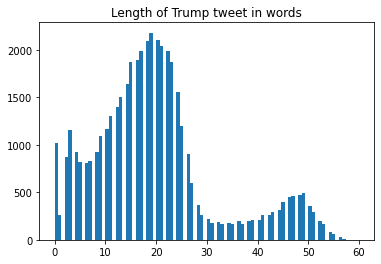

In [232]:
plt.hist(trump_no_ret.text_len,bins='auto');
plt.title('Length of Trump tweet in words');

In [233]:
max(trump_no_ret.text_len)

60

To train an RNN, we need to prepare input and output. In this case, we want to have our input as several consecutive words/punctuations from a sentence/tweet, and the output is the next word/punctuation in that sentence.  

In [234]:
for x in tf.data.Dataset.from_tensor_slices(trump_no_ret.text).take(3):
  print(x)

tf.Tensor(b'republicans and democrats have both created our economic problems.', shape=(), dtype=string)
tf.Tensor(b'i was thrilled to be back in the great city of charlotte, north carolina with thousands of hardworking american patriots who love our country, cherish our values, respect our laws, and always put america first! thank you for a wonderful evening!! #kag2020', shape=(), dtype=string)
tf.Tensor(b'the unsolicited mail in ballot scam is a major threat to our democracy, and the democrats know it. almost all recent elections using this system, even though much smaller and  with far fewer ballots to count, have ended up being a disaster. large numbers of missing ballots and fraud!', shape=(), dtype=string)


In [255]:
def keep_punc(text):
  text=text.replace('.',' . ')
  text=text.replace('?',' ? ')
  text=text.replace(',',' , ')
  text=text.replace('!',' ! ')
  text=text.replace(';',' ; ')
  text=text.replace(':',' : ')
  return text


In [257]:
trump_no_ret.text=trump_no_ret.text.map(keep_punc)

In [258]:
text_vectorizer = TextVectorization(
    standardize=None,
    output_mode="int"
)

In [259]:
text_data=tf.data.Dataset.from_tensor_slices(trump_no_ret.text)

start_time = time.time()
text_vectorizer.adapt(text_data.batch(64))
execution_time = (time.time() - start_time)/60.0
print("Execution time (mins)",execution_time)

Execution time (mins) 0.01852512756983439


In [260]:
vocabulary = text_vectorizer.get_vocabulary()
vocabulary_size = len(vocabulary)#49462
word_index = dict(zip(vocabulary, range(vocabulary_size)))
index_word=dict(zip( range(vocabulary_size),vocabulary))

In [264]:
print("Vocabulary:",vocabulary[:20])
print("Vocabulary Size:",len(vocabulary))

# Test our text vectorizer
test_text = list(text_data.take(1))[0]
print(test_text)
test_text_vector = text_vectorizer([test_text.numpy()])
print("Shape:",test_text_vector.shape)
print(test_text_vector[0])

Vocabulary: ['', '[UNK]', '.', ',', 'the', '!', 'to', 'and', 'a', 'of', ':', 'is', 'in', 'for', 'you', 'i', 'on', '@realdonaldtrump', 'be', 'will']
Vocabulary Size: 49462
tf.Tensor(b'republicans and democrats have both created our economic problems . ', shape=(), dtype=string)
Shape: (1, 10)
tf.Tensor([ 220    7  102   28  348 1167   27  523  671    2], shape=(10,), dtype=int64)


In [268]:
type([test_text.numpy()])

list

In [269]:
trump_no_ret.text[0]

'republicans and democrats have both created our economic problems . '

In [272]:
start_time = time.time()
tokenized_text=trump_no_ret.text.map(lambda x: text_vectorizer([x]).numpy())
execution_time = (time.time() - start_time)/60.0
print("Execution time (mins)",execution_time)

Execution time (mins) 3.046544631322225


In [274]:
tokenized_text=tokenized_text.map(lambda x: x[0])
tokenized_text.head()

0        [220, 7, 102, 28, 348, 1167, 27, 523, 671, 2]
1    [15, 37, 2054, 6, 18, 97, 12, 4, 20, 510, 9, 2...
3    [4, 5290, 2917, 12, 1484, 722, 11, 8, 401, 150...
5    [42, 14, 6, 39, 9, 4, 20, 129, 1456, 12, 4, 71...
7    [554, 324, 50, 8, 386, 275, 3, 13, 4, 349, 2, ...
Name: text, dtype: object

In [275]:
validation_percent = 0.20

# Split data into train / validate
train_tokenized_text, validate_tokenized_text = train_test_split(tokenized_text, test_size=validation_percent)

In [276]:
start_time = time.time()
seed_len=5
train_x=[]
train_y=[]
for row in train_tokenized_text:
    if len(row)<=seed_len:
      x,y = np.pad(row,(0,seed_len-len(row)),'constant'),0
      train_x.append(x)
      train_y.append(y)
    else: 
      for i in range(len(row)-seed_len):
        x,y= row[i:i+seed_len],row[i+seed_len]
        train_x.append(x)
        train_y.append(y)
train_y=np.array(train_y)
execution_time = (time.time() - start_time)/60.0
print("Execution time (mins)",execution_time)

Execution time (mins) 0.013580727577209472


In [277]:
start_time = time.time()
seed_len=5
val_x=[]
val_y=[]
for row in validate_tokenized_text:
    if len(row)<=seed_len:
      x,y = np.pad(row,(0,seed_len-len(row)),'constant'),0
      val_x.append(x)
      val_y.append(y)
    else: 
      for i in range(len(row)-seed_len):
        x,y= row[i:i+seed_len],row[i+seed_len]
        val_x.append(x)
        val_y.append(y)

execution_time = (time.time() - start_time)/60.0
print("Execution time (mins)",execution_time)

Execution time (mins) 0.003100156784057617


In [278]:
np.array(train_y).shape

(669386,)

In [279]:
batch_size = 1024
train_data = tf.data.Dataset.from_tensor_slices((train_x, np.array(train_y))).batch(batch_size).prefetch(512)
validation_data = tf.data.Dataset.from_tensor_slices((val_x, val_y)).batch(batch_size).prefetch(512)


The RNN, with LSTM and embedding.

In [293]:
def LSTM_model():
  input=layers.Input(shape=(seed_len,))
  embedding=layers.Embedding(vocabulary_size,50)(input)
  lstm=layers.LSTM(128)(embedding)
  drop=layers.Dropout(0.1)(lstm)
  output=layers.Dense(vocabulary_size,activation='softmax')(drop)
  model=Model(input,output)
  return model



In [294]:
trump_rnn=LSTM_model()
trump_rnn.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 5, 50)             2473100   
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               91648     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 49462)             6380598   
Total params: 8,945,346
Trainable params: 8,945,346
Non-trainable params: 0
_________________________________________________________________


In [295]:
learning_rate = 0.001
epochs = 100

optimizer = optimizers.Adam(learning_rate=learning_rate)
loss=losses.SparseCategoricalCrossentropy()

trump_rnn.compile(loss=loss,optimizer=optimizer, metrics=['accuracy'])

In [296]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto',restore_best_weights=True
)

start_time = time.time()
training_results = trump_rnn.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        callbacks=early_stopping,
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

Epoch 1/100
654/654 [==============================] - 33s 50ms/step - loss: 6.9465 - accuracy: 0.0701 - val_loss: 6.6034 - val_accuracy: 0.0730
Epoch 2/100
654/654 [==============================] - 32s 49ms/step - loss: 6.3781 - accuracy: 0.0933 - val_loss: 6.2886 - val_accuracy: 0.1035
Epoch 3/100
654/654 [==============================] - 32s 49ms/step - loss: 6.0420 - accuracy: 0.1159 - val_loss: 6.0410 - val_accuracy: 0.1267
Epoch 4/100
654/654 [==============================] - 33s 50ms/step - loss: 5.7620 - accuracy: 0.1404 - val_loss: 5.8381 - val_accuracy: 0.1510
Epoch 5/100
654/654 [==============================] - 32s 49ms/step - loss: 5.5315 - accuracy: 0.1619 - val_loss: 5.7021 - val_accuracy: 0.1644
Epoch 6/100
654/654 [==============================] - 33s 50ms/step - loss: 5.3490 - accuracy: 0.1756 - val_loss: 5.6097 - val_accuracy: 0.1733
Epoch 7/100
654/654 [==============================] - 32s 49ms/step - loss: 5.1945 - accuracy: 0.1855 - val_loss: 5.5429 - val_ac

In [297]:
def evaluate_model(model, training_results):
    
  # Get the model train history
  model_train_history = training_results.history
  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history["loss"])

  # Plot training results
  fig = plt.figure(figsize=(15,5))
  axs = fig.add_subplot(1,2,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in ["loss","val_loss"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()
  
  axs = fig.add_subplot(1,2,2)
  axs.set_title('Accuracy')
  # Plot all metrics
  for metric in ["accuracy","val_accuracy"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()

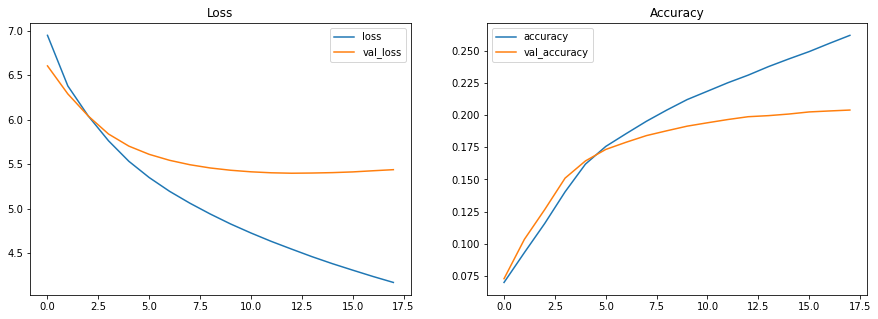

In [298]:
evaluate_model(trump_rnn,training_results)

In [356]:
def next_word(pred,temp=1):
  pred=np.array(pred[0]).astype('float64')
  pred=np.log(pred)/temp
  pred=np.exp(pred)
  pred=pred/np.sum(pred)
  next_word=np.random.multinomial(1,pred)
  return np.argmax(next_word)

def generate_tweet(seed,target_len=20,temp=1):
  #target length is 20 because the mode of tweet length is 20 
  seed=seed.split()
  
  if len(seed)>=seed_len:
    seed=seed[:seed_len]
    seed_token=[word_index[word] for word in seed]#list
    
  if len(seed)<seed_len:
    #randomly choose padding
    seed_token=[word_index[word] for word in seed]
    pad_num=seed_len-len(seed)
    for i in range(pad_num):
      invalid=True
      while invalid:
        pick_token=np.random.choice(range(vocabulary_size))
        pick_word=index_word[pick_token]
        if pick_word not in ['','[UNK]','.','?','!']:
          invalid=False
      seed_token.append(pick_token)
  generated_tweet=' '.join([index_word[index] for index in seed_token])
  for i in range(target_len):
    
    current_seed=np.array([seed_token])#1 X seed_len
    preds=trump_rnn.predict(current_seed)#1 X vocabulary_size
    nextword_token=next_word(preds,temp)
    nextword=index_word[nextword_token]
    generated_tweet=generated_tweet+' '+nextword
    if nextword in ['','[UNK]','.','?','!']:
      print('Early ended')
      return generated_tweet
    else:
      seed_token=seed_token[1:]
      seed_token.append(nextword_token)
    
  return generated_tweet



Generating "fake" Trump's tweets

In [357]:
generate_tweet('i will be')

Early ended


'i will be projecting sneak truth tonight at @lordandtaylor produces .'

Any insights from embedding layer?

In [347]:
embedding_layer_weight = trump_rnn.get_layer(name="embedding_5").get_weights()[0]
 

In [348]:
def find_similar(words, word_index, vocabulary, embedding_layer_weights, topn=5):
  subset_word_index  = []
  for word in words:
    subset_word_index.append(word_index[word])
 
  cs_op = cosine_similarity(embedding_layer_weights[subset_word_index], embedding_layer_weights)
  for idx in range(len(words)):
    top = cs_op[idx].argsort()[-topn:][::-1]
    for i,t in enumerate(top):
      if i ==0:
        print("Similar words for:",vocabulary[t])
      else:
        print("    ",vocabulary[t])

In [349]:
find_similar(['hello','trump'],word_index,vocabulary,embedding_layer_weight)

Similar words for: hello
     happens
     belongs
     apologize
     #nypd
Similar words for: trump
     #trump
     cylindrical
     obama
     golf--trump


## Save the model

In [359]:
trump_rnn.save('trump_rnn_model.h5') 